## Setup

In [164]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from statsforecast.core import StatsForecast
from statsforecast.models import SeasonalNaive
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast.models import Naive

#GOLD_PATH = '/home/lucas-nunes/workspace/Postech/challenges/2_ibov/data/gold'

GOLD_PATH = "./"

PERIOD_SEAZONAL_NAIVE_WEEKLY = 7
PERIOD_SEAZONAL_NAIVE_MONTHLY = 30
PREDICTION_DAYS = 90

MIN_THRESHOLD_VALID = 0.70 # Value should be at least this value to be considered on the Model

LIST_COLUMNS_DF_FILTER = ['data', 'ultimo']

## Read

In [165]:
df = pd.read_parquet(f'{GOLD_PATH}/gold.parquet')
list_value_columns = df.columns.to_list()
list_value_columns.remove('data')
list_value_columns.remove('ibov')
list_value_columns.remove('ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov_futuro')
list_value_columns.insert(len(list_value_columns), 'ibov')
list_value_columns

['prata',
 'us30',
 'ouro',
 'spx',
 'ndx',
 'petroleo',
 'vix',
 'eur_brl',
 'usd_brl',
 'ibrx100',
 'BBSA3',
 'CPLE6',
 'ITUB4',
 'VALE3',
 'PETR3',
 'ELET3',
 'ibrx50',
 'FTXIN9',
 'RENT3',
 'us500',
 'SLCE3',
 'cobre',
 'FLRY3',
 'bitcoin',
 'ferro',
 'MGLU3',
 'STOXX50E',
 'ethereum',
 'CRFB3',
 'ibov_futuro',
 'ibov']

## Correlations

In [166]:
df_2k = df.where(df['data'] > datetime.date(2000, 1, 1)).dropna(how='all')

In [167]:
correlation_matrix = df[list_value_columns].corr()
correlation_matrix_only_ibov = df[list_value_columns].corr()[['ibov']].sort_values(by='ibov')
correlation_matrix_2k = df_2k[list_value_columns].corr()

In [168]:
list_index_within_threshold = [key for key, value in correlation_matrix['ibov'].to_dict().items() if value > MIN_THRESHOLD_VALID]

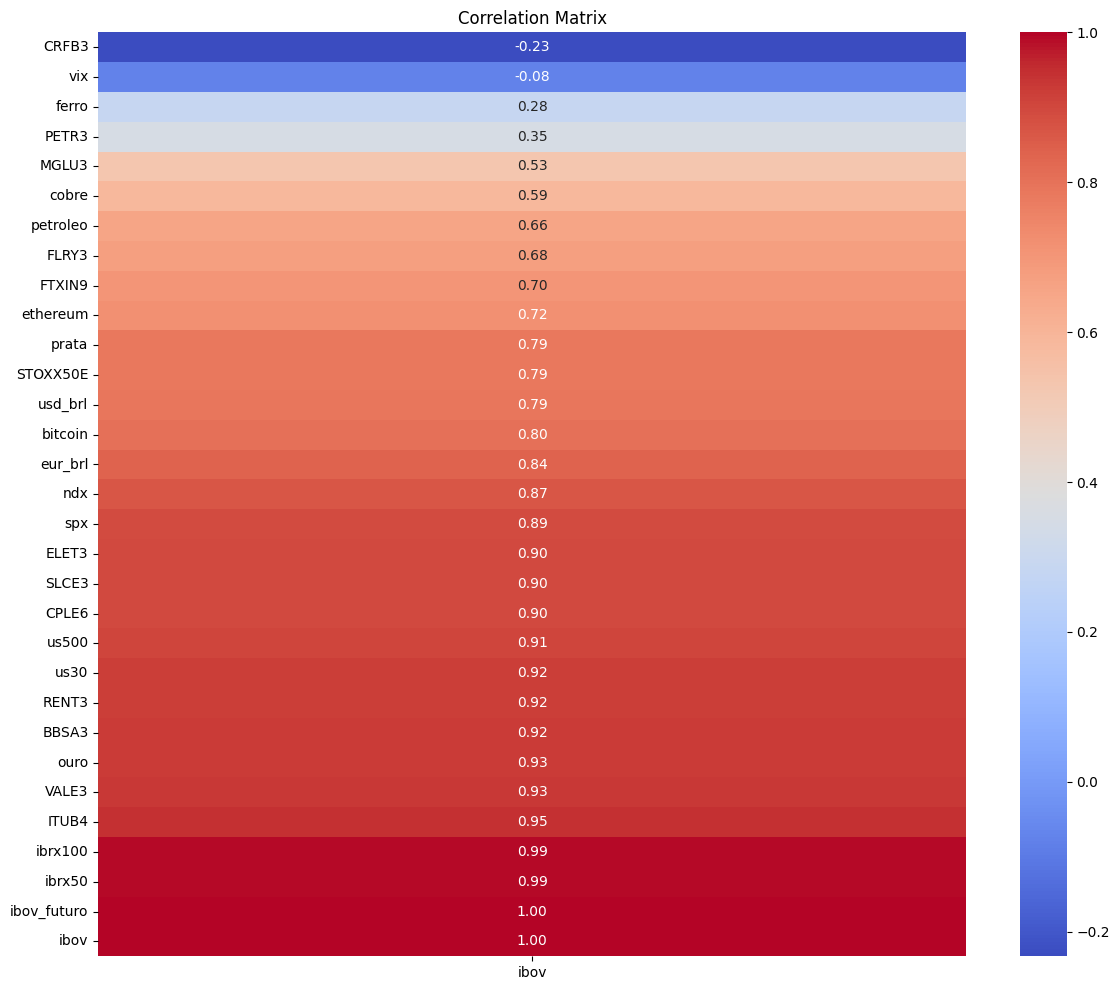

In [169]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_only_ibov, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

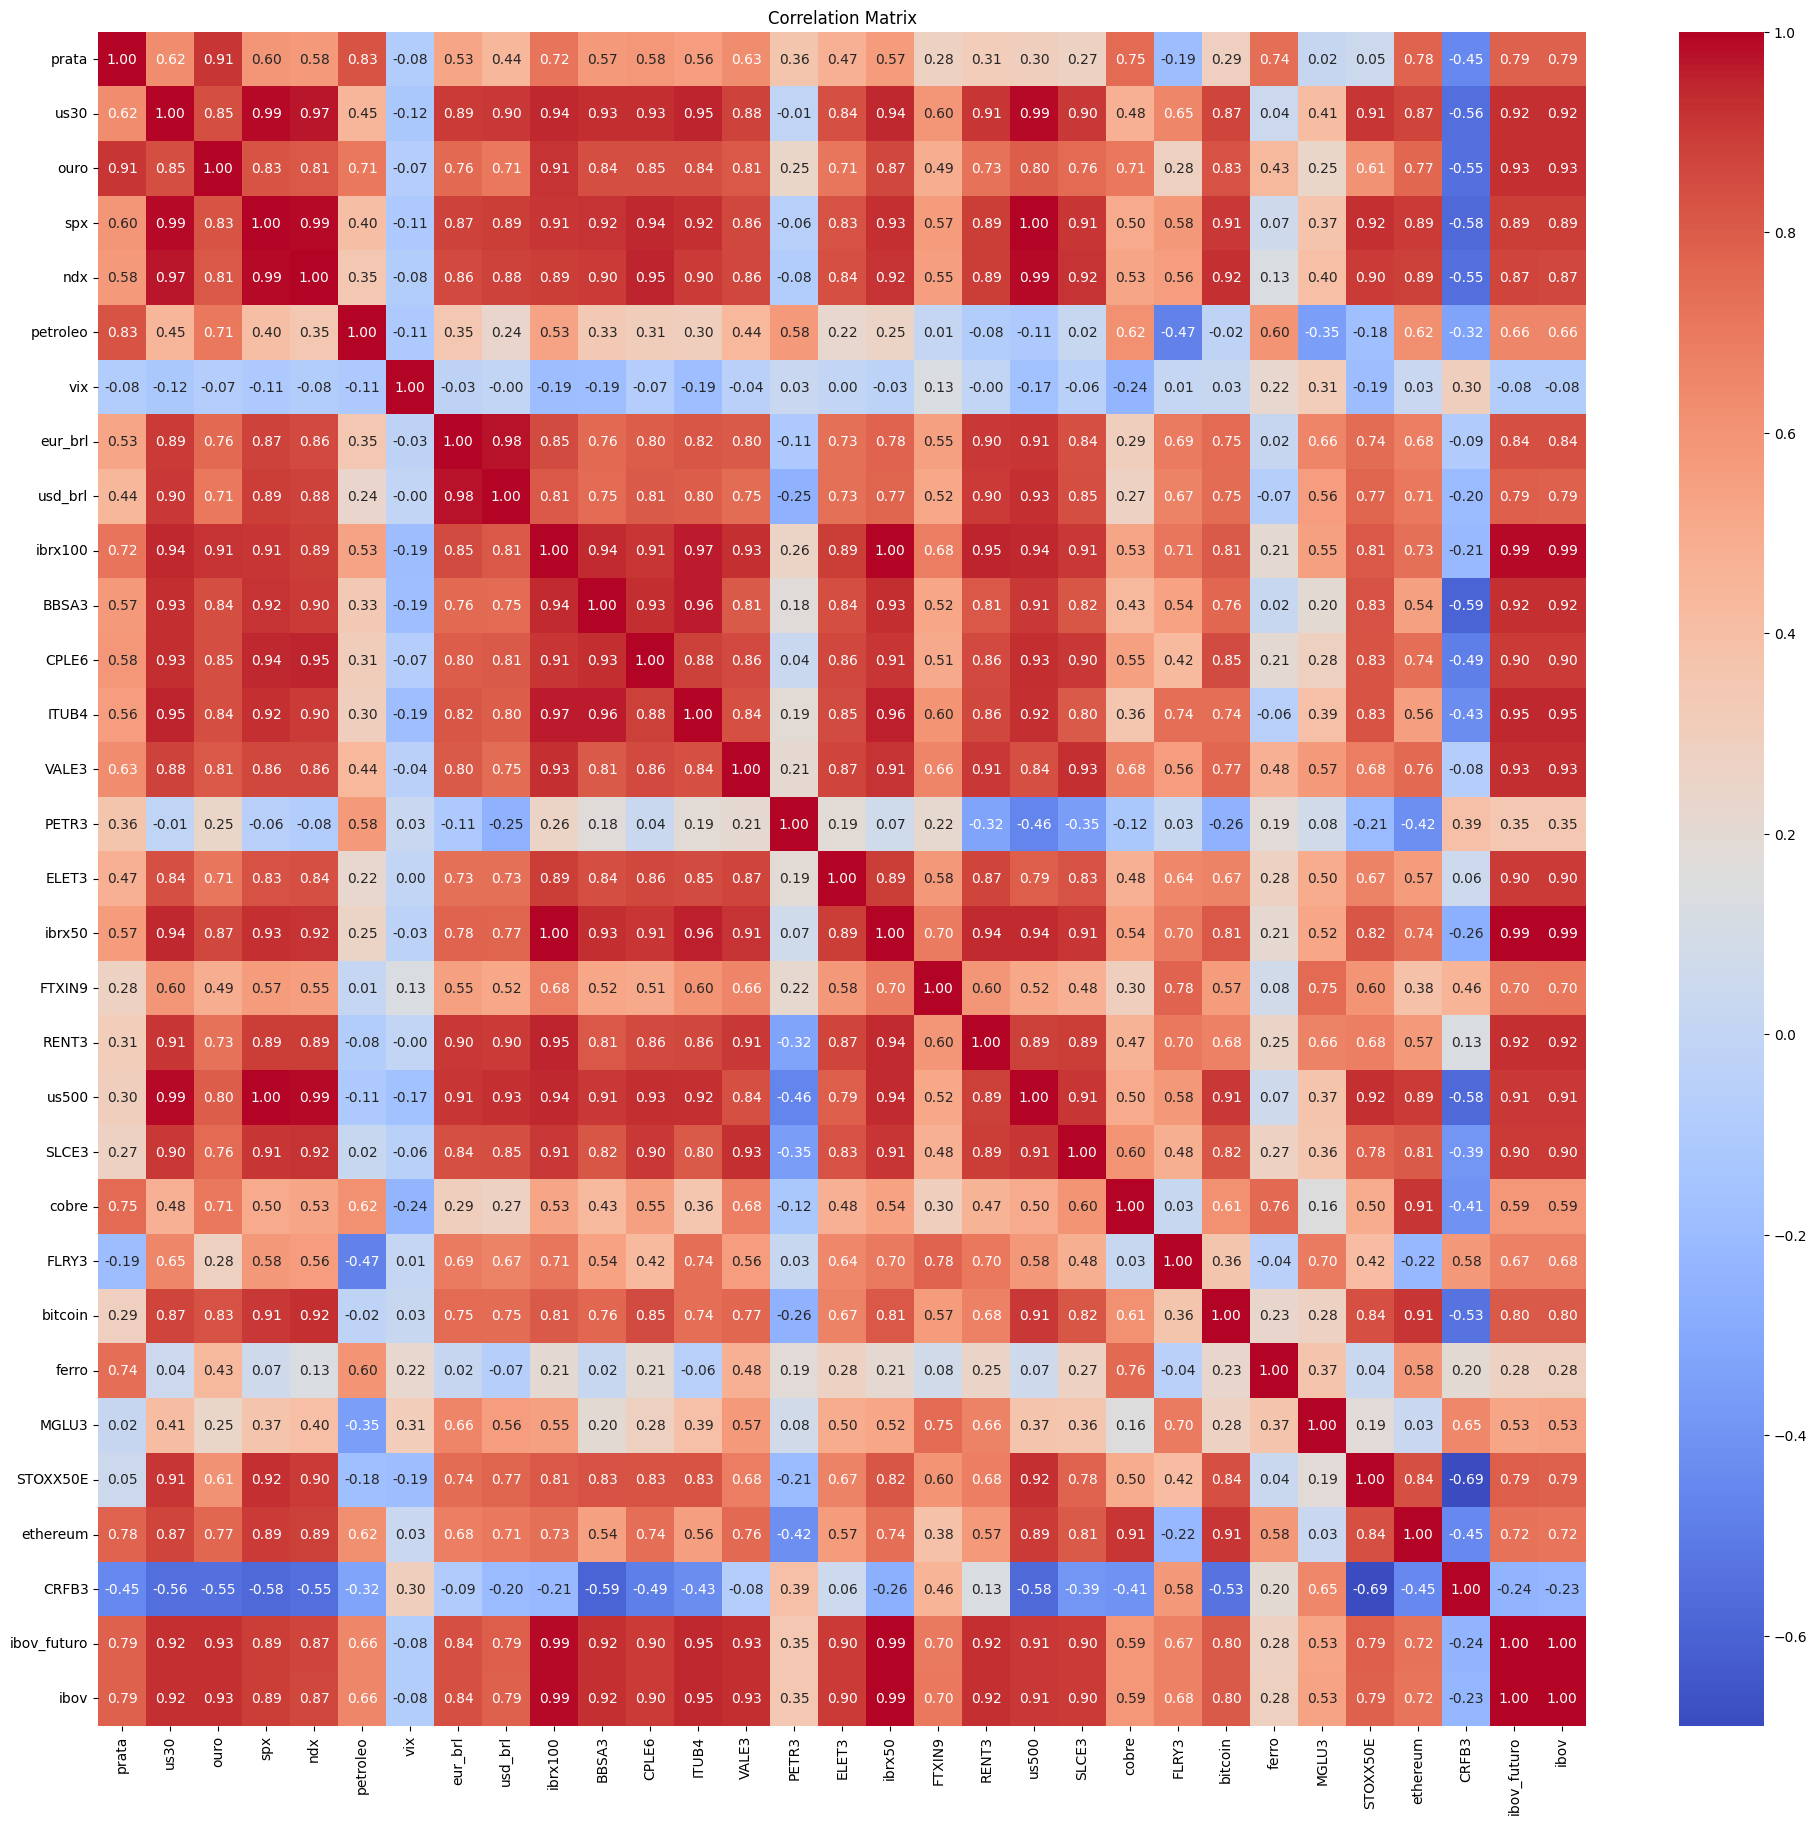

In [170]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

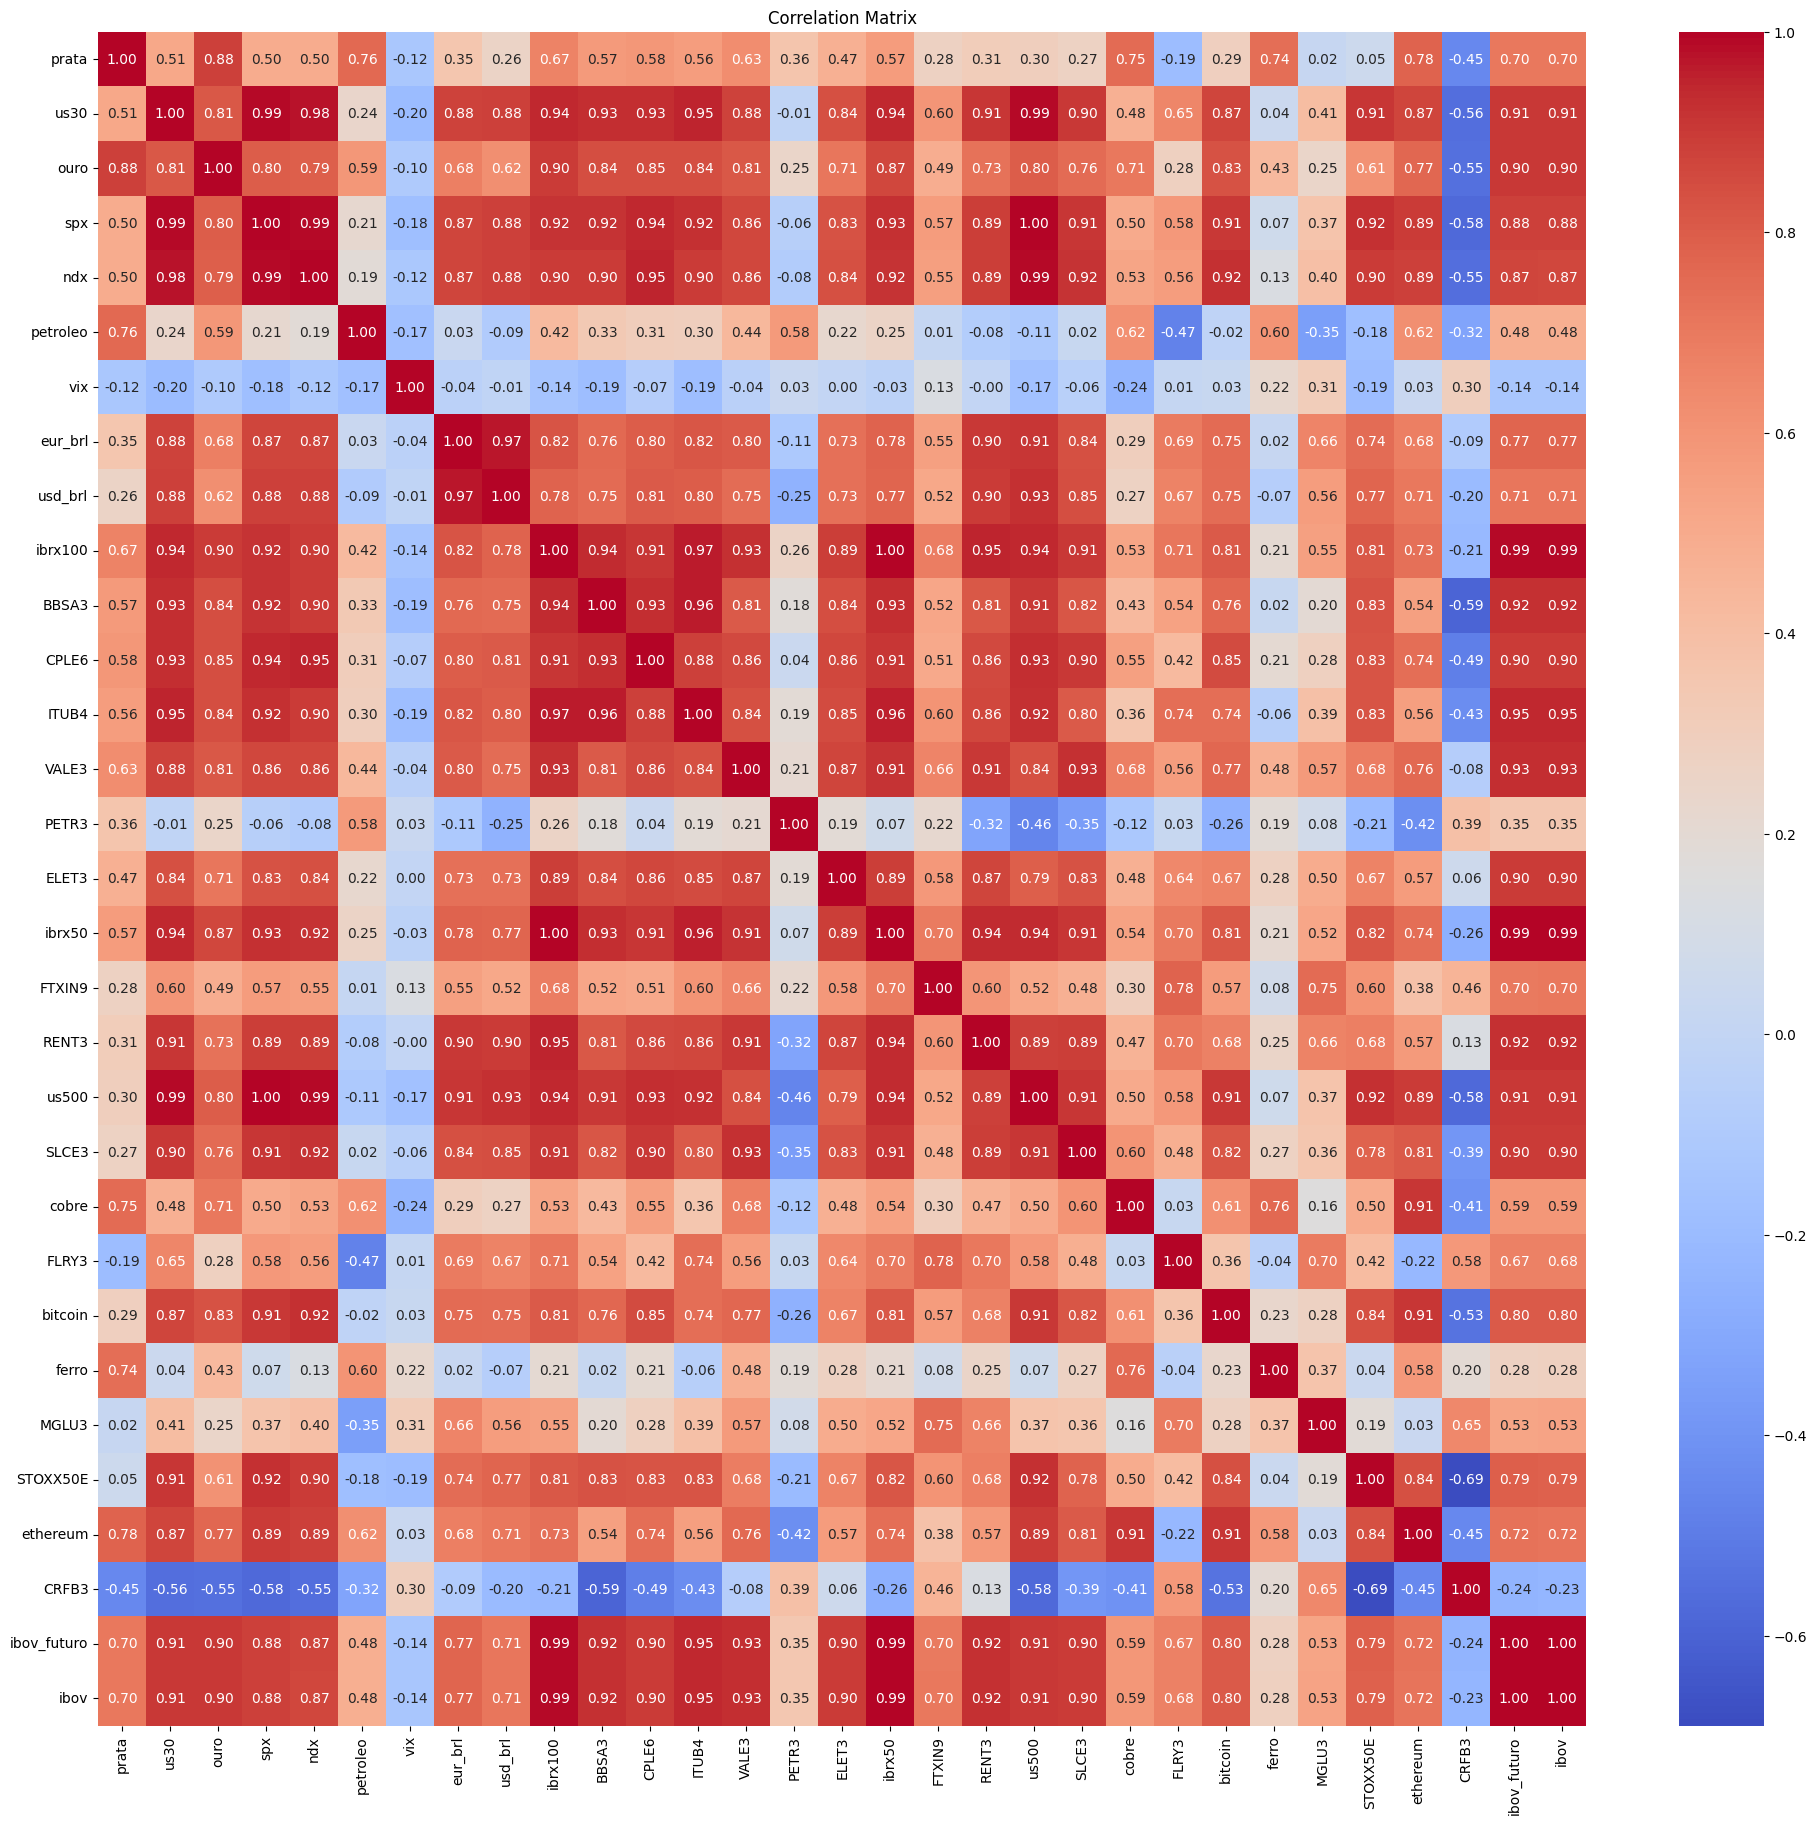

In [171]:
plt.figure(figsize=(24, 22))
sns.heatmap(correlation_matrix_2k, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Timeseries Forecast Model

### ARIMA

In [172]:
df_training = df.where(df['data'] <= datetime.date(2025,1,1)).dropna(how='all')
# Set 'data' column as index
df_training.set_index('data', inplace=True)

# Select the column to forecast, for example 'ultimo'
ts = df_training['ibov']

# Fit ARIMA model
model_naive = ARIMA(ts, order=(5, 1, 0))  # (p, d, q) order of the model
model_fit = model_naive.fit()

# Forecast
forecast_steps = PREDICTION_DAYS
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new datetime index for the forecast steps
forecast_dates = pd.date_range(start=ts.index[-1], periods=forecast_steps)

# Combine the forecast dates with the forecast values
forecast_series = pd.Series(forecast.values, index=forecast_dates)

# Print the forecast with datetime index
print(forecast_series)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2025-01-01    120282.892983
2025-01-02    120282.957206
2025-01-03    120282.850504
2025-01-04    120282.857380
2025-01-05    120282.856515
                  ...      
2025-03-27    120282.858099
2025-03-28    120282.858099
2025-03-29    120282.858099
2025-03-30    120282.858099
2025-03-31    120282.858099
Freq: D, Length: 90, dtype: float64


In [173]:
df_test = df.where(df['data'] >= datetime.date(2025,1,1)).dropna(how='all')
df_test = df_test[['data', 'ibov']]

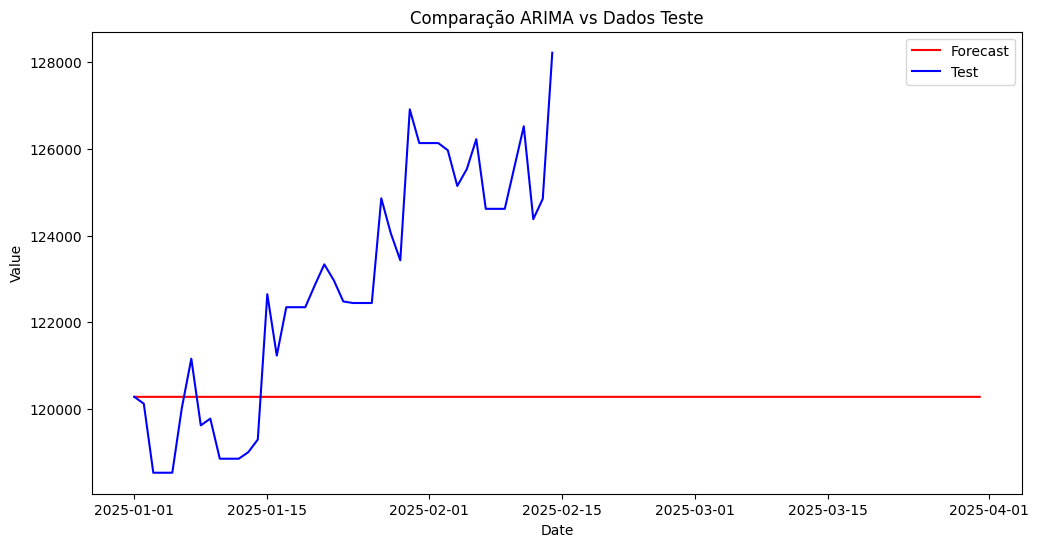

In [174]:
# Plot the comparison between forecast_series and df_test
plt.figure(figsize=(12, 6))
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(df_test['data'], df_test['ibov'], label='Test', color='blue')
plt.title('Comparação ARIMA vs Dados Teste')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

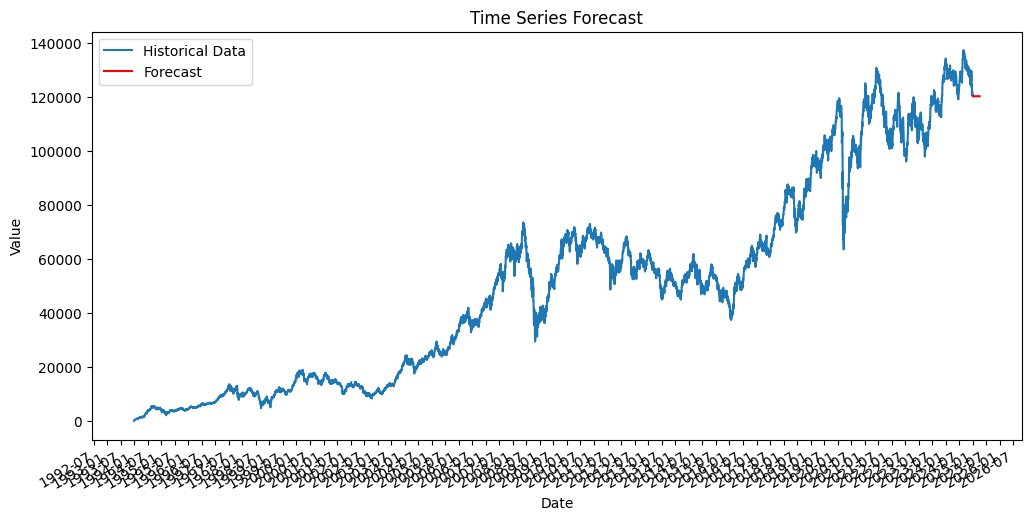

In [175]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data')
plt.plot(forecast, label='Forecast', color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [176]:
ts = df_test['ibov']

In [177]:
df_forecast = pd.DataFrame({'forecast': forecast_series}).reset_index().rename(columns={'index': 'data'})

df_forecast['data'] = df_forecast['data'].apply(lambda x: x.date())
df_forecast = df_forecast.merge(right=df_test)
df_forecast['diff'] = df_forecast['ibov'] - df_forecast['forecast']
df_forecast['diff_perc'] = abs(df_forecast['ibov'] - df_forecast['forecast'])/df_forecast['ibov']
df_forecast['precision'] = 1 - df_forecast['diff_perc']

In [178]:
df_forecast['precision'].mean()
# df_forecast['precision'].median()

np.float64(0.9751046429068028)

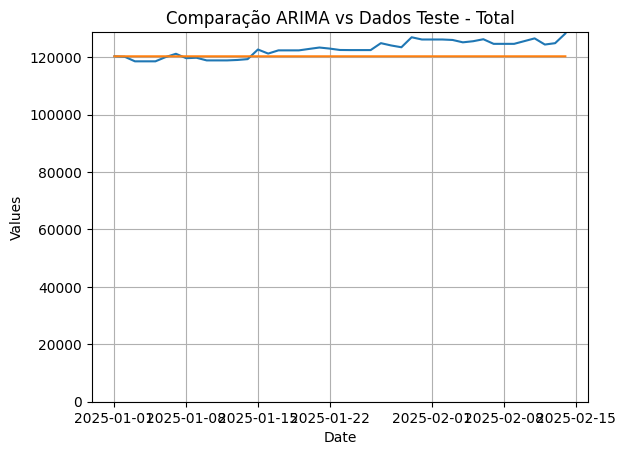

<Figure size 1200x600 with 0 Axes>

In [179]:

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['ibov'], label='Value')
ax.plot(df_forecast['data'], df_forecast['forecast'], label='Forecast')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação ARIMA vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

plt.show()

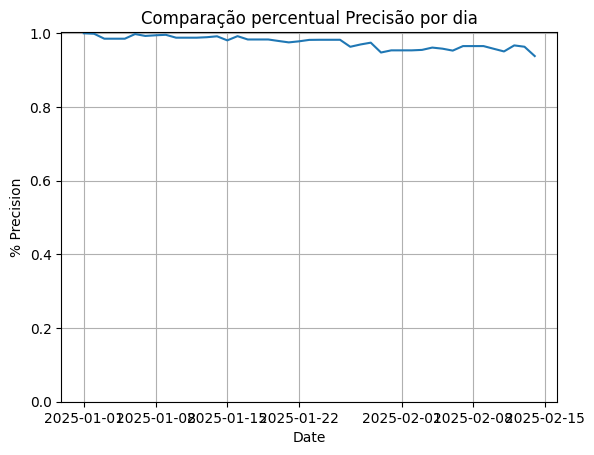

<Figure size 1200x600 with 0 Axes>

In [180]:
df_precision = df_forecast[['data', 'precision']]

fig, ax = plt.subplots()

plt.figure(figsize=(12, 6))

ax.plot(df_precision['data'], df_precision['precision'], label='a')
ax.set_ylim(ymin=0)
ax.grid()
ax.set(
    xlabel='Date',
    ylabel='% Precision',
    title='Comparação percentual Precisão por dia'
)

plt.show()

In [181]:
"""from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(ts[-forecast_steps:], forecast)
mse = mean_squared_error(ts[-forecast_steps:], forecast)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')"""

"from sklearn.metrics import mean_absolute_error, mean_squared_error\n\n# Calculate MAE and MSE\nmae = mean_absolute_error(ts[-forecast_steps:], forecast)\nmse = mean_squared_error(ts[-forecast_steps:], forecast)\n\nprint(f'Mean Absolute Error (MAE): {mae}')\nprint(f'Mean Squared Error (MSE): {mse}')"

### Seasonal NAIVE

In [182]:
# Função para calcular WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(y_true) + 1e-10)  # Evita erro de divisão por zero

def seazonal_naive(df, period, prediction_days):
  # Filtragem dos dados entre 2000 e 2024
  base_filtrada = df[(df['data'] >= datetime.date(2000, 1, 1)) & (df['data'] <= datetime.datetime.now().date())].copy()

  # Ordenação por data
  base_filtrada.sort_values(by="data", inplace=True)

  # Tratamento de valores ausentes
  print("Valores ausentes antes do tratamento:")
  print(base_filtrada.isnull().sum())
  base_filtrada.fillna(method='ffill', inplace=True)
  base_filtrada.fillna(method='bfill', inplace=True)
  assert base_filtrada.isnull().sum().sum() == 0, "Ainda existem valores ausentes!"

  # Estruturação para modelagem
  base_filtrada = base_filtrada[['data', 'ibov']].reset_index(drop=True)
  base_filtrada.rename(columns={'data': 'ds', 'ibov': 'y'}, inplace=True)
  assert pd.api.types.is_numeric_dtype(base_filtrada['y']), "Erro: a coluna 'y' não é numérica!"

  # Análise de sazonalidade
  decomposicao = seasonal_decompose(base_filtrada.set_index('ds')['y'], period=period) # Considerando sazonalidade de mensal, caso a gente queira mudar (semanal (7) / trimestral (90) / semestral (180) / anual (365), alterar aqui)
  decomposicao.plot()
  plt.show()

  # Definição do corte entre treino e validação
  cutoff_date = datetime.date(2024, 12, 31)
  treino = base_filtrada[base_filtrada['ds'] <= cutoff_date].copy()
  valid = base_filtrada[base_filtrada['ds'] > cutoff_date].copy()

  # Verificação do tamanho dos conjuntos
  tamanho_treino, tamanho_valid = treino.shape[0], valid.shape[0]
  print(f"Tamanho do Treino: {tamanho_treino} | Tamanho da Validação: {tamanho_valid}")
  assert tamanho_valid > 0, "Erro: O conjunto de validação está vazio!"

  # Definição do horizonte de previsão
  h = tamanho_valid

  # Preparação dos dados para o modelo
  treino['unique_id'] = 'IBOV'

  # Configuração e treinamento do modelo
  model_s = StatsForecast(models=[SeasonalNaive(season_length=period)], freq='D', n_jobs=-1) # Considerando sazonalidade de mensal, caso a gente queira mudar (semanal (7) / trimestral (90) / semestral (180) / anual (365), alterar aqui)
  model_s.fit(treino[['unique_id', 'ds', 'y']])

  # Fazer previsão para o mesmo período da validação
  forecast_df = model_s.predict(h=h, level=[prediction_days])
  forecast_df['ds'] = pd.to_datetime(forecast_df['ds']).apply(lambda x: x.date())

  # Merge com valores reais
  forecast_df = forecast_df.merge(valid, on='ds', how='left')
  forecast_df.dropna(subset=['y', 'SeasonalNaive'], inplace=True)

  forecast_df['diff_perc'] = abs(forecast_df['y'] - forecast_df['SeasonalNaive'])/forecast_df['y']
  forecast_df['precision'] = 1 - forecast_df['diff_perc']

  # Cálculo do erro WMAPE
  if not forecast_df.empty and forecast_df['y'].sum() > 0:
      erro_wmape = wmape(forecast_df['y'].values, forecast_df['SeasonalNaive'].values)
      print(f'WMAPE: {erro_wmape:.2%}')
  else:
      print("Erro: Não há valores suficientes para calcular WMAPE.")

  return treino, valid, forecast_df

# Função para plotar os resultados
def plot_forecast(treino, valid, forecast_df, title="Previsão do IBOVESPA"):
    plt.figure(figsize=(12, 6))
    plt.plot(treino['ds'], treino['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['SeasonalNaive-lo-90'], forecast_df['SeasonalNaive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()  # Pega o início da validação para focar no zoom
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['SeasonalNaive'], label="Previsão (SeasonalNaive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['SeasonalNaive-lo-90'], forecast_df['SeasonalNaive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())  # Define um range menor para foco na previsão
    plt.show()

Valores ausentes antes do tratamento:
data              0
prata             0
us30              0
ouro              0
spx               0
ibov              0
ndx               0
petroleo          0
vix               0
ibov_futuro       0
eur_brl           0
usd_brl           0
ibrx100           0
BBSA3             3
CPLE6             3
ITUB4             3
VALE3             3
PETR3            11
ELET3           357
ibrx50         1099
FTXIN9         1526
RENT3          1971
us500          2196
SLCE3          2726
cobre          3108
FLRY3          3640
bitcoin        3852
ferro          3951
MGLU3          4141
STOXX50E       4245
ethereum       5914
CRFB3          6412
dtype: int64


<ipython-input-182-8f3dcfa20d86>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='ffill', inplace=True)
<ipython-input-182-8f3dcfa20d86>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='bfill', inplace=True)


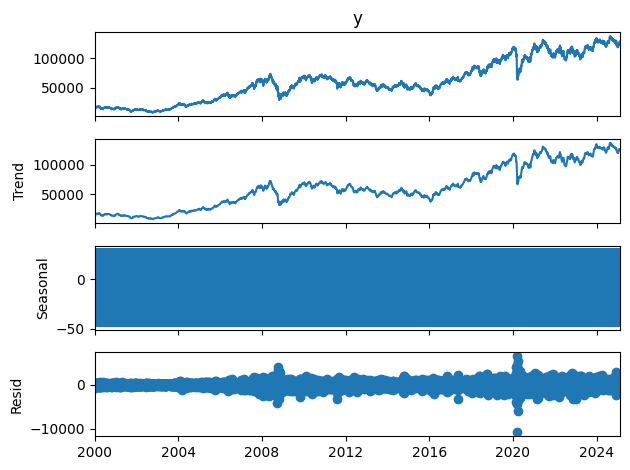

Tamanho do Treino: 9132 | Tamanho da Validação: 45
WMAPE: 2.45%


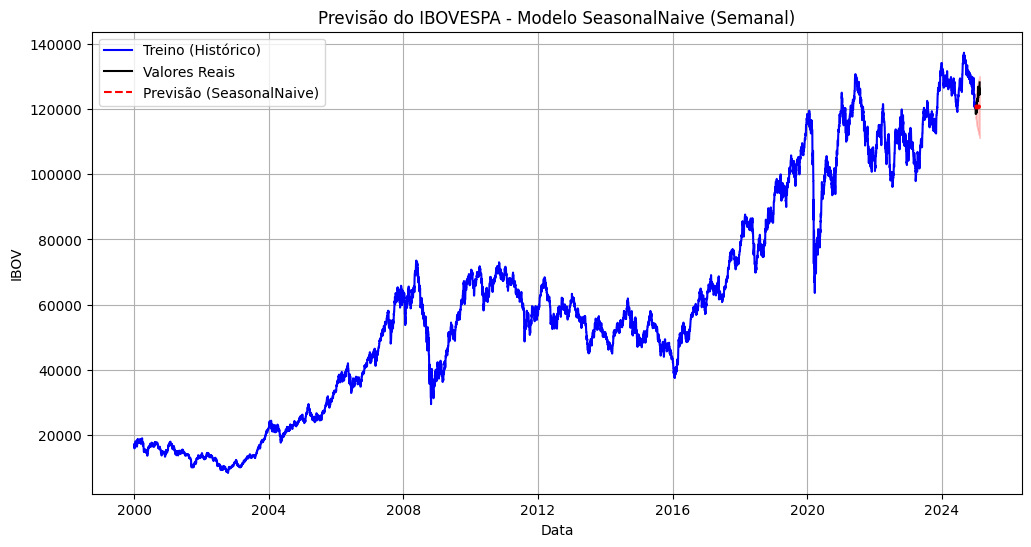

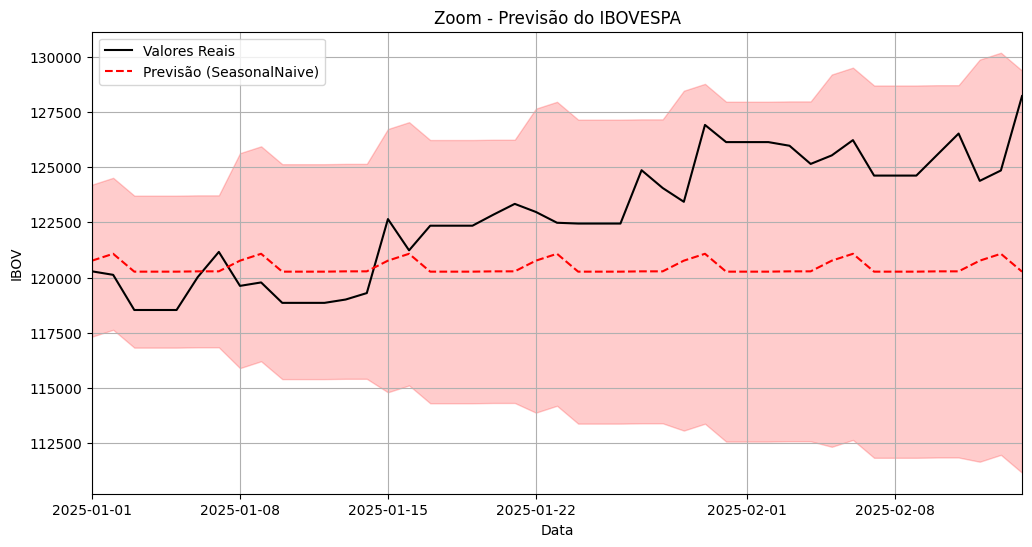

In [183]:
treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive = seazonal_naive(df, PERIOD_SEAZONAL_NAIVE_WEEKLY, PREDICTION_DAYS)

# Plot dos resultados
plot_forecast(treino_seazonal_naive, valid_seazonal_naive, forecast_df_seazonal_naive, "Previsão do IBOVESPA - Modelo SeasonalNaive (Semanal)")

Valores ausentes antes do tratamento:
data              0
prata             0
us30              0
ouro              0
spx               0
ibov              0
ndx               0
petroleo          0
vix               0
ibov_futuro       0
eur_brl           0
usd_brl           0
ibrx100           0
BBSA3             3
CPLE6             3
ITUB4             3
VALE3             3
PETR3            11
ELET3           357
ibrx50         1099
FTXIN9         1526
RENT3          1971
us500          2196
SLCE3          2726
cobre          3108
FLRY3          3640
bitcoin        3852
ferro          3951
MGLU3          4141
STOXX50E       4245
ethereum       5914
CRFB3          6412
dtype: int64


<ipython-input-182-8f3dcfa20d86>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='ffill', inplace=True)
<ipython-input-182-8f3dcfa20d86>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='bfill', inplace=True)


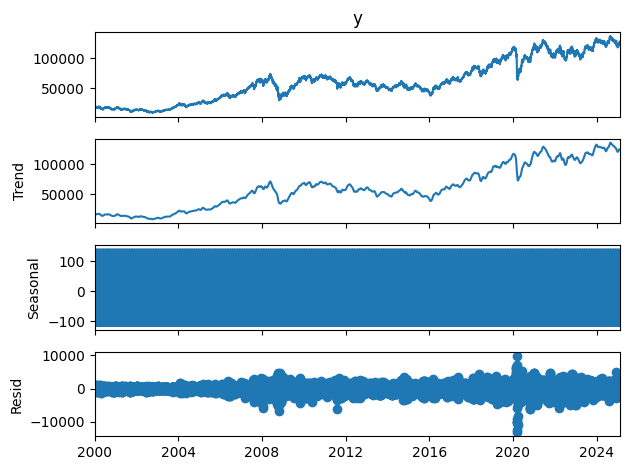

Tamanho do Treino: 9132 | Tamanho da Validação: 45
WMAPE: 2.83%


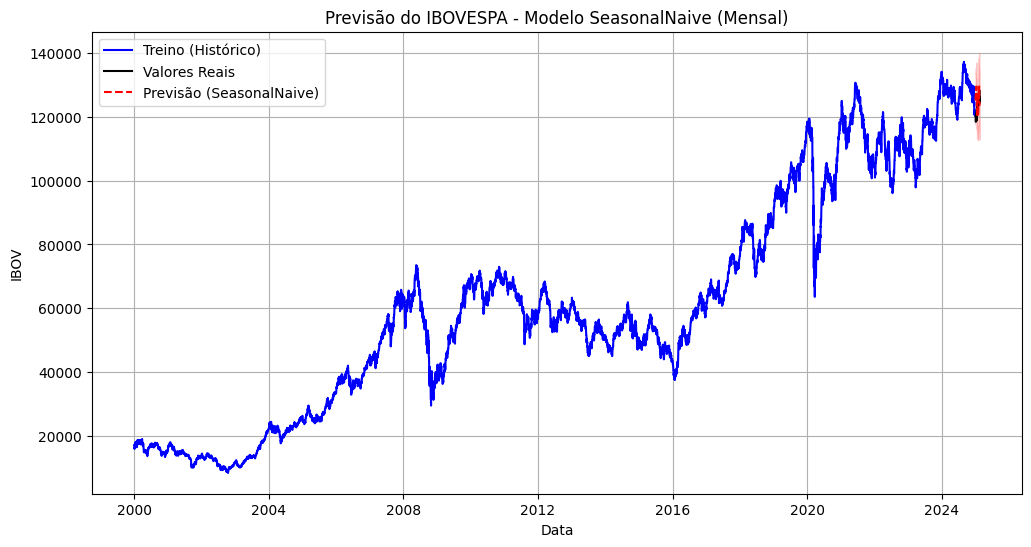

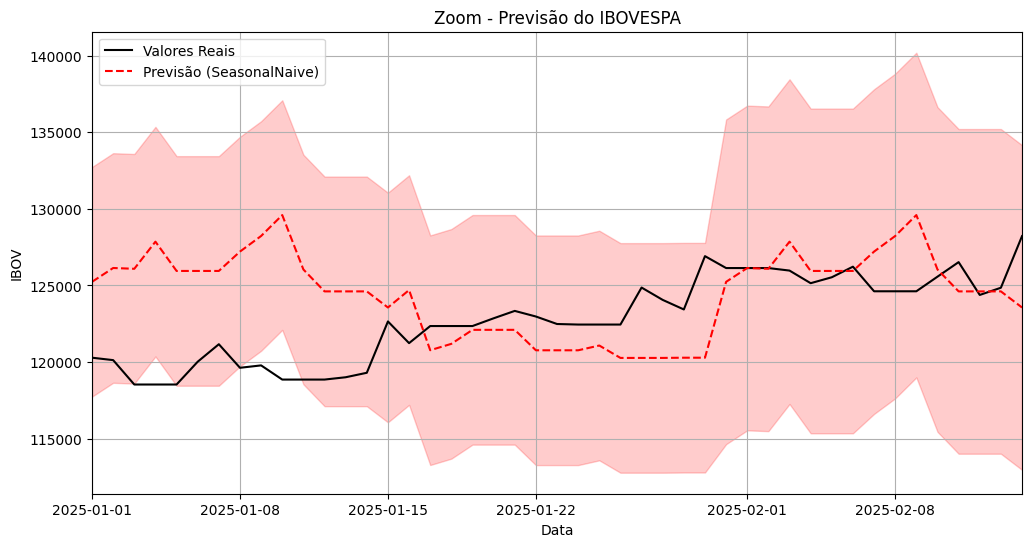

In [184]:
treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month = seazonal_naive(df, PERIOD_SEAZONAL_NAIVE_MONTHLY, PREDICTION_DAYS)

# Plot dos resultados
plot_forecast(treino_seazonal_naive_month, valid_seazonal_naive_month, forecast_df_seazonal_naive_month, "Previsão do IBOVESPA - Modelo SeasonalNaive (Mensal)")

### NAIVE

Valores ausentes antes do tratamento:
data              0
prata             0
us30              0
ouro              0
spx               0
ibov              0
ndx               0
petroleo          0
vix               0
ibov_futuro       0
eur_brl           0
usd_brl           0
ibrx100           0
BBSA3             3
CPLE6             3
ITUB4             3
VALE3             3
PETR3            11
ELET3           357
ibrx50         1099
FTXIN9         1526
RENT3          1971
us500          2196
SLCE3          2726
cobre          3108
FLRY3          3640
bitcoin        3852
ferro          3951
MGLU3          4141
STOXX50E       4245
ethereum       5914
CRFB3          6412
dtype: int64
Tamanho do Treino: 9132 | Tamanho da Validação: 45
WMAPE: 2.52%


<ipython-input-185-ed879e73c124>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='ffill', inplace=True)
<ipython-input-185-ed879e73c124>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  base_filtrada.fillna(method='bfill', inplace=True)


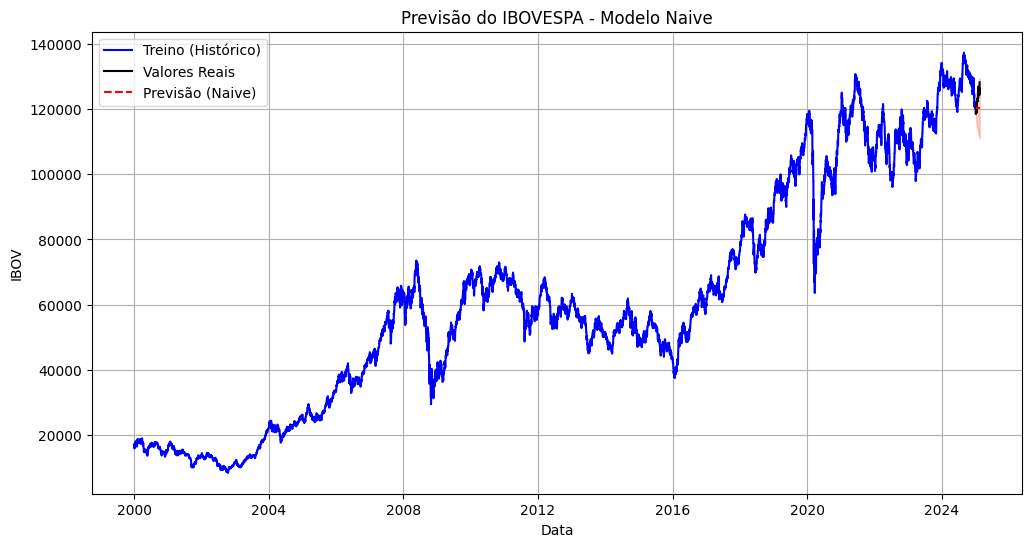

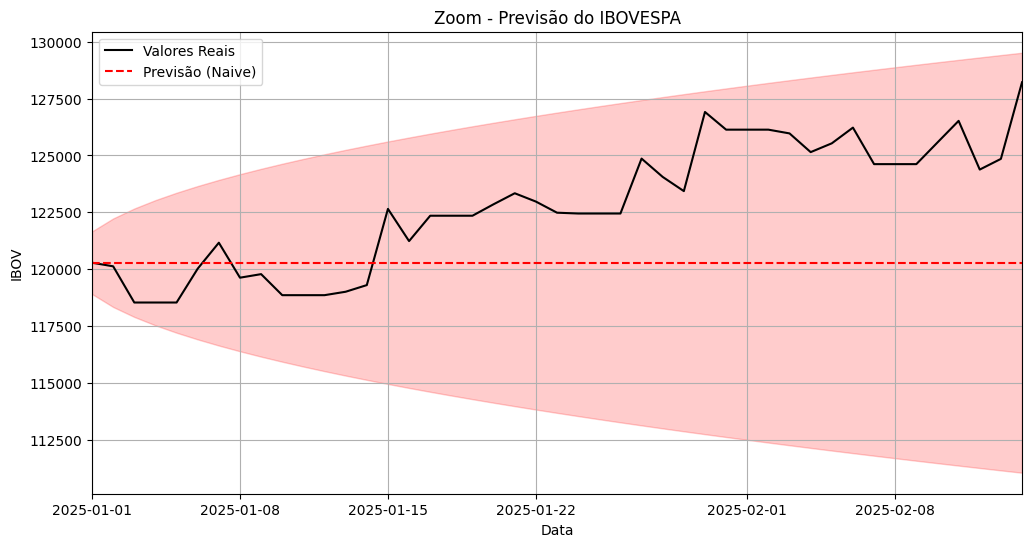

In [185]:
# Filtragem dos dados entre 2000 e 2024
base_filtrada = df[(df['data'] >= datetime.date(2000, 1, 1)) & (df['data'] <= datetime.datetime.now().date())].copy()

# Ordenação por data
base_filtrada.sort_values(by="data", inplace=True)

# Tratamento de valores ausentes
print("Valores ausentes antes do tratamento:")
print(base_filtrada.isnull().sum())
base_filtrada.fillna(method='ffill', inplace=True)
base_filtrada.fillna(method='bfill', inplace=True)
assert base_filtrada.isnull().sum().sum() == 0, "Ainda existem valores ausentes!"

# Estruturação para modelagem
base_filtrada = base_filtrada[['data', 'ibov']].reset_index(drop=True)
base_filtrada.rename(columns={'data': 'ds', 'ibov': 'y'}, inplace=True)
assert pd.api.types.is_numeric_dtype(base_filtrada['y']), "Erro: a coluna 'y' não é numérica!"

# Definição do corte entre treino e validação
cutoff_date = datetime.date(2024, 12, 31)
treino_naive = base_filtrada[base_filtrada['ds'] <= cutoff_date].copy()
valid_naive = base_filtrada[base_filtrada['ds'] > cutoff_date].copy()

# Verificação do tamanho dos conjuntos
tamanho_treino, tamanho_valid = treino_naive.shape[0], valid_naive.shape[0]
print(f"Tamanho do Treino: {tamanho_treino} | Tamanho da Validação: {tamanho_valid}")
assert tamanho_valid > 0, "Erro: O conjunto de validação está vazio!"

# Definição do horizonte de previsão
h = tamanho_valid

# Preparação dos dados para o modelo
treino_naive['unique_id'] = 'IBOV'

# Configuração e treinamento do modelo
model_naive = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model_naive.fit(treino_naive[['unique_id', 'ds', 'y']])

# Fazer previsão para o mesmo período da validação
forecast_df_naive = model_naive.predict(h=h, level=[PREDICTION_DAYS])
forecast_df_naive['ds'] = pd.to_datetime(forecast_df_naive['ds']).apply(lambda x: x.date())

# Merge com valores reais
forecast_df_naive = forecast_df_naive.merge(valid_naive, on='ds', how='left')
forecast_df_naive.dropna(subset=['y', 'Naive'], inplace=True)

forecast_df_naive['diff_perc'] = abs(forecast_df_naive['y'] - forecast_df_naive['Naive'])/forecast_df_naive['y']
forecast_df_naive['precision'] = 1 - forecast_df_naive['diff_perc']

# Cálculo do erro WMAPE
if not forecast_df_naive.empty and forecast_df_naive['y'].sum() > 0:
    erro_wmape = wmape(forecast_df_naive['y'].values, forecast_df_naive['Naive'].values)
    print(f'WMAPE: {erro_wmape:.2%}')
else:
    print("Erro: Não há valores suficientes para calcular WMAPE.")

# Função para plotar os resultados
def plot_forecast_naive(treino, valid, forecast_df, title="Previsão do IBOVESPA - Modelo Naive"):
    plt.figure(figsize=(12, 6))
    plt.plot(treino['ds'], treino['y'], label="Treino (Histórico)", color="blue")
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['Naive-lo-90'], forecast_df['Naive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    # Adicionar zoom na parte final
    plt.figure(figsize=(12, 6))
    zoom_start = valid['ds'].min()
    plt.plot(valid['ds'], valid['y'], label="Valores Reais", color="black")
    plt.plot(forecast_df['ds'], forecast_df['Naive'], label="Previsão (Naive)", color="red", linestyle="dashed")
    plt.fill_between(forecast_df['ds'], forecast_df['Naive-lo-90'], forecast_df['Naive-hi-90'], color='red', alpha=0.2)
    plt.xlabel("Data")
    plt.ylabel("IBOV")
    plt.title("Zoom - Previsão do IBOVESPA")
    plt.legend()
    plt.grid()
    plt.xlim(zoom_start, forecast_df['ds'].max())
    plt.show()

# Plot dos resultados
plot_forecast_naive(treino_naive, valid_naive, forecast_df_naive)

### Other 2

### Comparação de resultado entre modelos

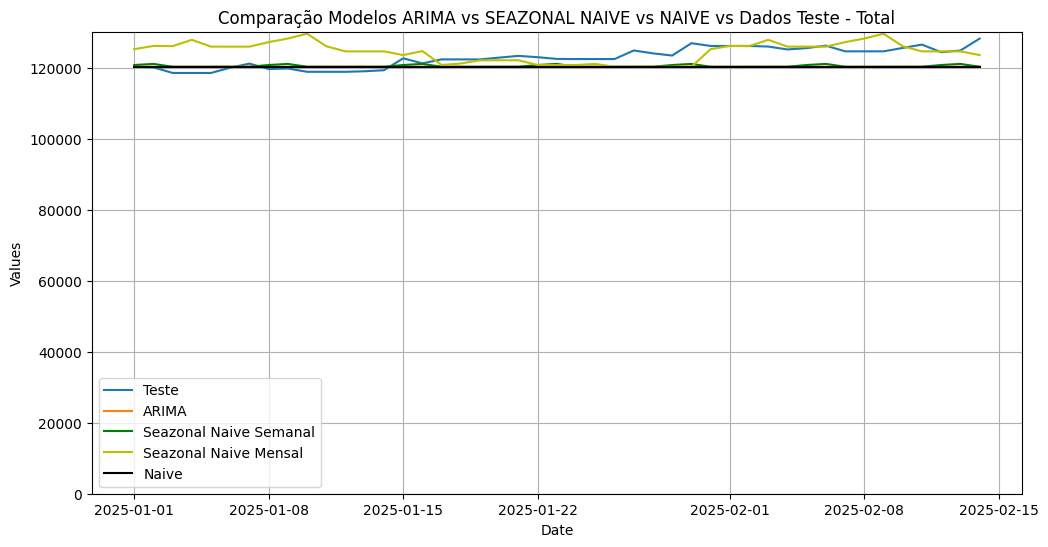

In [186]:
# Plot the comparison between forecast_series and df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['ibov'], label='Teste')
ax.plot(df_forecast['data'], df_forecast['forecast'], label='ARIMA')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['SeasonalNaive'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['SeasonalNaive'], label='Seazonal Naive Mensal', color='y')
ax.plot(forecast_df_naive['ds'], forecast_df_naive['Naive'], label='Naive', color='black')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

ax.legend()

plt.show()

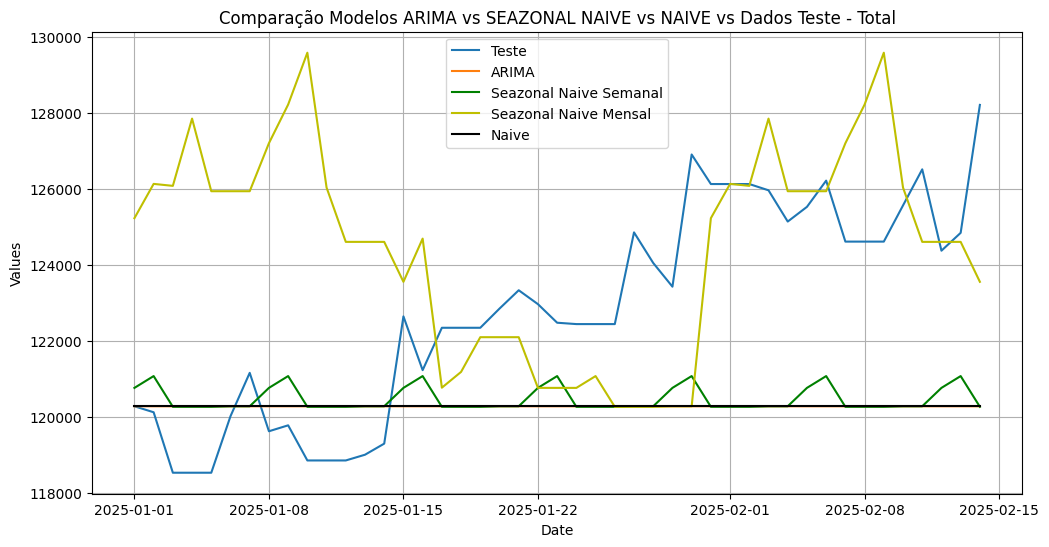

In [187]:
# Plot the comparison between forecast_series and df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['ibov'], label='Teste')
ax.plot(df_forecast['data'], df_forecast['forecast'], label='ARIMA')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['SeasonalNaive'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['SeasonalNaive'], label='Seazonal Naive Mensal', color='y')
ax.plot(forecast_df_naive['ds'], forecast_df_naive['Naive'], label='Naive', color='black')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.legend()

plt.show()

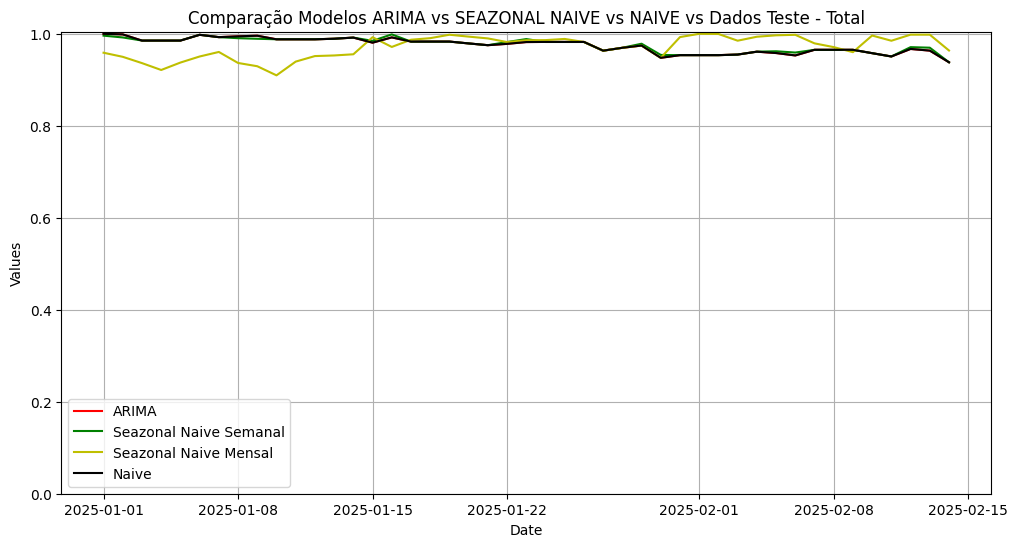

In [196]:
# Plot the comparison between forecast_series and df_test
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_forecast['data'], df_forecast['precision'], label='ARIMA', color='r')
ax.plot(forecast_df_seazonal_naive['ds'], forecast_df_seazonal_naive['precision'], label='Seazonal Naive Semanal', color='g')
ax.plot(forecast_df_seazonal_naive_month['ds'], forecast_df_seazonal_naive_month['precision'], label='Seazonal Naive Mensal', color='y')
ax.plot(forecast_df_naive['ds'], forecast_df_naive['precision'], label='Naive', color='black')

ax.grid()
ax.set(
    xlabel='Date',
    ylabel='Values',
    title='Comparação Modelos ARIMA vs SEAZONAL NAIVE vs NAIVE vs Dados Teste - Total'
)

ax.set_ylim(ymin=0)

ax.legend()

plt.show()

In [201]:
print(f"""
ARIMA: {round(df_forecast['precision'].mean(), 2)}
SEAZONAL NAIVE SEMANAL: {round(forecast_df_seazonal_naive['precision'].mean(), 2)}
SEAZONAL NAIVE MENSAL: {round(forecast_df_seazonal_naive_month['precision'].mean(), 2)}
NAIVE: {round(forecast_df_naive['precision'].mean(), 2)}
""")


ARIMA: 0.98
SEAZONAL NAIVE SEMANAL: 0.98
SEAZONAL NAIVE MENSAL: 0.97
NAIVE: 0.98

